In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 256
learning_rate = 0.0002
num_epoch = 20

mnist_train = dset.MNIST("./",
                         train=True,
                         transform=transforms.ToTensor(),
                         target_transform=None,
                         download=True)
mnist_test  = dset.MNIST("./",
                         train=False,
                         transform=transforms.ToTensor(),
                         target_transform=None,
                         download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2,
                                           drop_last=True)
test_loader  = torch.utils.data.DataLoader(mnist_test,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=2,
                                           drop_last=True)


In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        r"""input : 28*28 single channel image
            28*28
        -> nn.Conv2d(1, 16, 5)  : kernel=(5,5), stride=1, padding=0
        -> 24*24 : (28-4)*(28-4)
        -> nn.Conv2d(16, 32, 5) : kernel=(5,5), stride=1, padding=0
        -> 20*20 : (24-4)*(24-4)
        -> nn.MaxPool2d(2, 2)   : window=(2,2), stride=2
        -> 10*10 : (20/2)*(20/2)
        -> nn.Conv2d(32, 64, 5) : kernel=(5,5), stride=1, padding=0
        -> 6*6   : (10-4)*(10-4)
        -> nn.MaxPool2d(2, 2)   : window=(2,2), stride=2
        -> 3*3   : (6/2)*(6/2)
        """
        self.fc_layer = nn.Sequential(
            nn.Linear(64*(3*3), 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model

device: cuda


CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [4]:
# train
loss_array = []
for i in range(num_epoch):
    for j, (image, label) in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_array.append(loss.cpu().detach().numpy())

# test
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y = label.to(device)
        
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        total += label.size(0)
        correct += (output_index == y).sum().float()
        
    print(f"Accuracy of Test Data: {100*correct/total}")

tensor(2.3036, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3152, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2247, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1287, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0999, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0331, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0504, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0742, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0422, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0256, device='cuda:0', grad_fn=<NllLossBackward

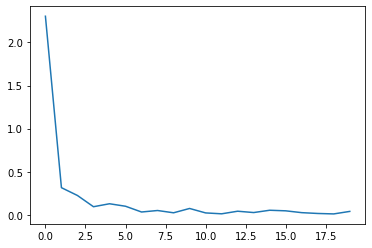

In [5]:
import matplotlib.pyplot as plt

plt.plot(loss_array)
plt.show()